<a href="https://colab.research.google.com/github/j1zha/DSC_180B/blob/main/transformer_nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
pip install scikit-learn matplotlib pandas numpy yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [4]:
start_date = "2024-01-01"
end_date = datetime.now()
nvda_data = yf.download("NVDA", start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
scaler = MinMaxScaler()
nvda_data_scaled = scaler.fit_transform(nvda_data[['Close']])
seq_length = 10
X, Y = [], []

for i in range(len(nvda_data_scaled) - seq_length):
    X.append(nvda_data_scaled[i:i+seq_length])
    Y.append(nvda_data_scaled[i+seq_length])

X, Y = np.array(X), np.array(Y)

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

In [6]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=3, dim_feedforward=256, output_dim=1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_layer = nn.Linear(input_dim, d_model) #linear transformation transform 1D to 64D
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_length, d_model))  # Positional encoding to make models
        # know which days are more important

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers) #Using self attention to learn the relations
        # between different days. Self attention assign different weights on different days since to find patterns.

        self.fc = nn.Linear(d_model, output_dim) # Apply a fully connected (FC) layer to convert the final output to one number.

    def forward(self, x):
        x = self.input_layer(x)
        x = x + self.pos_encoder
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x
# Select the last time stamp for the output
model = TimeSeriesTransformer()


In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/50], Loss: 0.6872
Epoch [10/50], Loss: 0.0409
Epoch [20/50], Loss: 0.0402
Epoch [30/50], Loss: 0.0099
Epoch [40/50], Loss: 0.0113


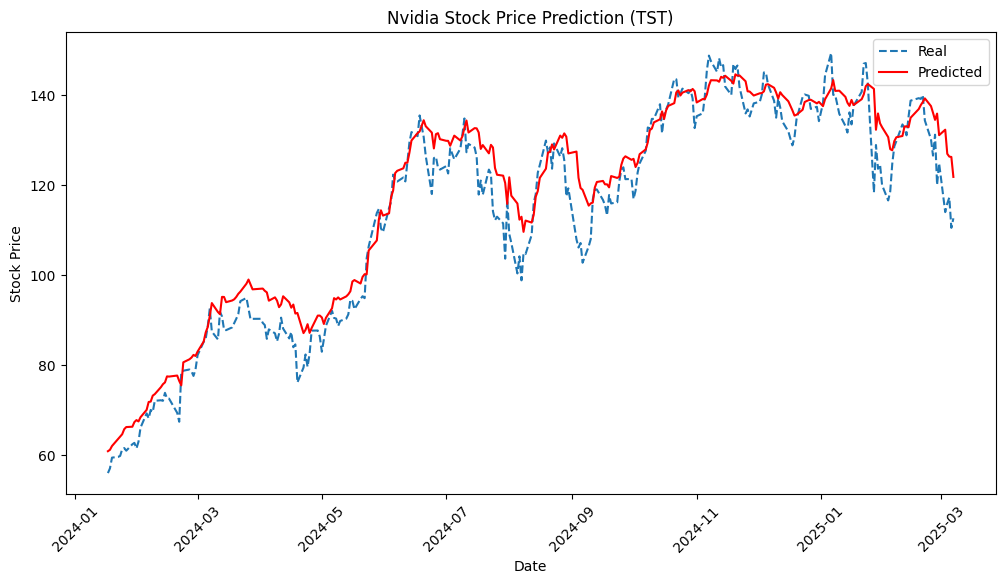

In [8]:
model.eval()
predictions = model(X_train).detach().numpy()

predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())

dates = nvda_data.index[seq_length:]


plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (TST)")
plt.xticks(rotation=45)
plt.show()


In [11]:
differences = (Y_real.flatten() - predictions.flatten()).tolist()

In [9]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_real, predictions))
print(f"RMSE: {rmse:.4f}")

RMSE: 6.2397


In [12]:
print("Y_real:", Y_real.flatten().tolist())
print("predictions:", predictions.flatten().tolist())
print("differences:",differences)

Y_real: [56.037113189697266, 57.09081268310547, 59.47413635253906, 59.6370964050293, 59.85603713989258, 61.344608306884766, 61.59953308105469, 61.01369857788086, 62.447296142578125, 62.75619888305664, 61.509559631347656, 63.00913619995117, 66.14125061035156, 69.3123550415039, 68.20366668701172, 70.0791244506836, 69.62125396728516, 72.11255645751953, 72.22752380371094, 72.10755920410156, 73.87905883789062, 72.63740539550781, 72.59241485595703, 69.43231964111328, 67.452880859375, 78.51573944091797, 78.7946548461914, 79.06958770751953, 78.6786880493164, 77.6409912109375, 79.0895767211914, 82.25567626953125, 85.21283721923828, 85.94366455078125, 88.67901611328125, 92.6470718383789, 87.5073013305664, 85.75371551513672, 91.8912582397461, 90.86650085449219, 87.9231948852539, 87.81621551513672, 88.43407440185547, 89.37686157226562, 90.35062408447266, 91.41336822509766, 94.2667007446289, 94.97952270507812, 92.53910064697266, 90.22864532470703, 90.33462524414062, 90.34162139892578, 89.4308395385

In [15]:
pip install properscoring

In [16]:
from properscoring import crps_gaussian
sigma = np.std(Y_real - predictions)
crps = np.mean(crps_gaussian(Y_real, predictions, sigma))
print(f"CRPS: {crps:.4f}")

CRPS: 3.4788


# "The Transformer model takes past stock prices as input and uses self-attention to learn patterns between different days. It applies positional encoding to capture time order and processes the data through multiple Transformer encoder layers. The model then extracts the last time step’s output and uses a fully connected layer to generate the final stock price prediction."

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [17]:
nvda_close = nvda_data[['Close']].values

scaler = MinMaxScaler()
nvda_close_scaled = scaler.fit_transform(nvda_close)


seq_length = 10
X, Y = [], []

for i in range(len(nvda_close_scaled) - seq_length):
    X.append(nvda_close_scaled[i:i+seq_length])
    Y.append(nvda_close_scaled[i+seq_length])

X, Y = np.array(X), np.array(Y)

X_train = torch.tensor(X, dtype=torch.float32).unsqueeze(1).squeeze(-1)
Y_train = torch.tensor(Y, dtype=torch.float32)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: torch.Size([286, 1, 10])
Y_train shape: torch.Size([286, 1])


In [18]:
class TemporalConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3):
        super(TemporalConvNet, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=4, dilation=4)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, padding=8, dilation=8)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x[:, :, -1]
        x = self.fc(x)
        return x

model = TemporalConvNet(input_dim=1, hidden_dim=64, output_dim=1)

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [0/50], Loss: 0.5786
Epoch [10/50], Loss: 0.1570
Epoch [20/50], Loss: 0.0380
Epoch [30/50], Loss: 0.0303
Epoch [40/50], Loss: 0.0173


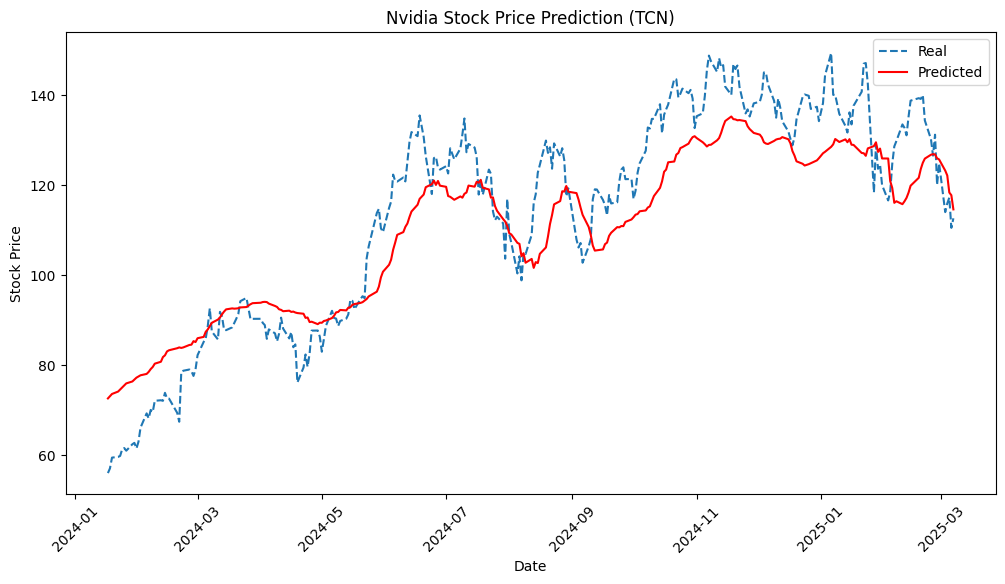

In [22]:

model.eval()
predictions = model(X_train).detach().numpy()

predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())

rmse = np.sqrt(mean_squared_error(Y_real, predictions))

try:
    from properscoring import crps_gaussian
    sigma = np.std(Y_real - predictions)
    crps = np.mean(crps_gaussian(Y_real, predictions, sigma))
except ModuleNotFoundError:
    crps = None

dates = nvda_data.index[seq_length:]

plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (TCN)")
plt.xticks(rotation=45)
plt.show()


In [23]:
rmse, crps

(10.321319692643664, 5.993935)

In [ ]:
differences = (Y_real.flatten() - predictions.flatten()).tolist()

In [ ]:
print("Y_real:", Y_real.flatten().tolist())
print("predictions:", predictions.flatten().tolist())
print("differences:",differences)

Y_real: [56.037113189697266, 57.09081268310547, 59.47413635253906, 59.637088775634766, 59.85603713989258, 61.344608306884766, 61.59953308105469, 61.01369857788086, 62.447296142578125, 62.75619888305664, 61.509559631347656, 63.00913619995117, 66.14124298095703, 69.3123550415039, 68.20366668701172, 70.0791244506836, 69.62125396728516, 72.11255645751953, 72.22752380371094, 72.10755920410156, 73.87905883789062, 72.63740539550781, 72.59241485595703, 69.43231201171875, 67.452880859375, 78.5157470703125, 78.79467010498047, 79.06958770751953, 78.6786880493164, 77.6409912109375, 79.0895767211914, 82.25567626953125, 85.21283721923828, 85.94366455078125, 88.67901611328125, 92.6470718383789, 87.5073013305664, 85.75371551513672, 91.89126586914062, 90.86650085449219, 87.9231948852539, 87.81621551513672, 88.43407440185547, 89.37686157226562, 90.35062408447266, 91.41336822509766, 94.26669311523438, 94.97952270507812, 92.53910064697266, 90.22864532470703, 90.33462524414062, 90.34162139892578, 89.430839

In [ ]:
dates_str = [str(date.date()) for date in dates]  # dates 是你的日期数组
model2_data = {
    "dates": dates_str,
    "Y_real": Y_real.flatten().tolist(),
    "predictions": predictions.flatten().tolist(),
    "differences": differences
}
with open("model2_data.json", "w") as f:
    json.dump(model2_data, f)



In [ ]:
from google.colab import files
files.download("model1_data.json")
files.download("model2_data.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [0/50], Loss: 0.4598
Epoch [10/50], Loss: 0.0447
Epoch [20/50], Loss: 0.0235
Epoch [30/50], Loss: 0.0113
Epoch [40/50], Loss: 0.0083


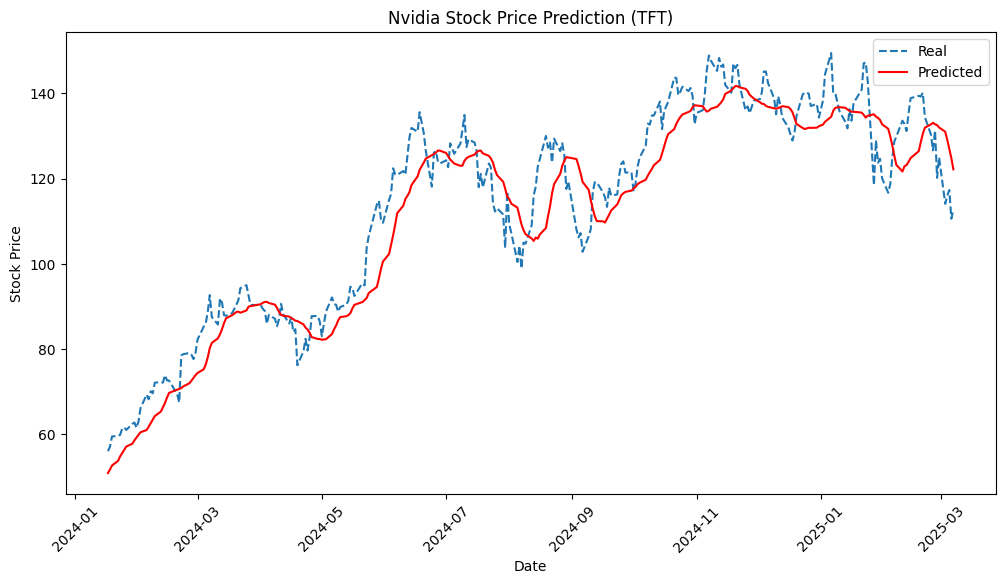

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

start_date = "2024-01-01"
end_date = datetime.now()
nvda_data = yf.download("NVDA", start=start_date, end=end_date)

scaler = MinMaxScaler()
nvda_data_scaled = scaler.fit_transform(nvda_data[['Close']])

seq_length = 10
X, Y = [], []
for i in range(len(nvda_data_scaled) - seq_length):
    X.append(nvda_data_scaled[i:i+seq_length])
    Y.append(nvda_data_scaled[i+seq_length])

X, Y = np.array(X), np.array(Y)
X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.1, output_size=1):
        super(TemporalFusionTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.input_embedding(x)
        encoder_output, _ = self.encoder(x)

        query = encoder_output[:, -1:, :]
        attn_output, _ = self.attention(query, encoder_output, encoder_output)
        attn_output = self.dropout(attn_output)
        out = self.fc(attn_output.squeeze(1))
        return out
model = TemporalFusionTransformer()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
predictions = model(X_train).detach().numpy()
predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())
dates = nvda_data.index[seq_length:]

plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (TFT)")
plt.xticks(rotation=45)
plt.show()


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_real, predictions))
print("RMSE:", rmse)

try:
    from properscoring import crps_gaussian
    sigma = np.std(Y_real.flatten() - predictions.flatten())
    crps = np.mean(crps_gaussian(Y_real.flatten(), predictions.flatten(), sigma))
    print("CRPS:", crps)
except ModuleNotFoundError:
    print("properscoring module not installed; cannot compute CRPS.")


RMSE: 7.844116931858794
CRPS: 4.498256


[*********************100%***********************]  1 of 1 completed


Epoch [0/50], Loss: 0.4787
Epoch [10/50], Loss: 0.1857
Epoch [20/50], Loss: 0.0776
Epoch [30/50], Loss: 0.0505
Epoch [40/50], Loss: 0.0349
RMSE: 16.87035435908718
CRPS: 9.747298


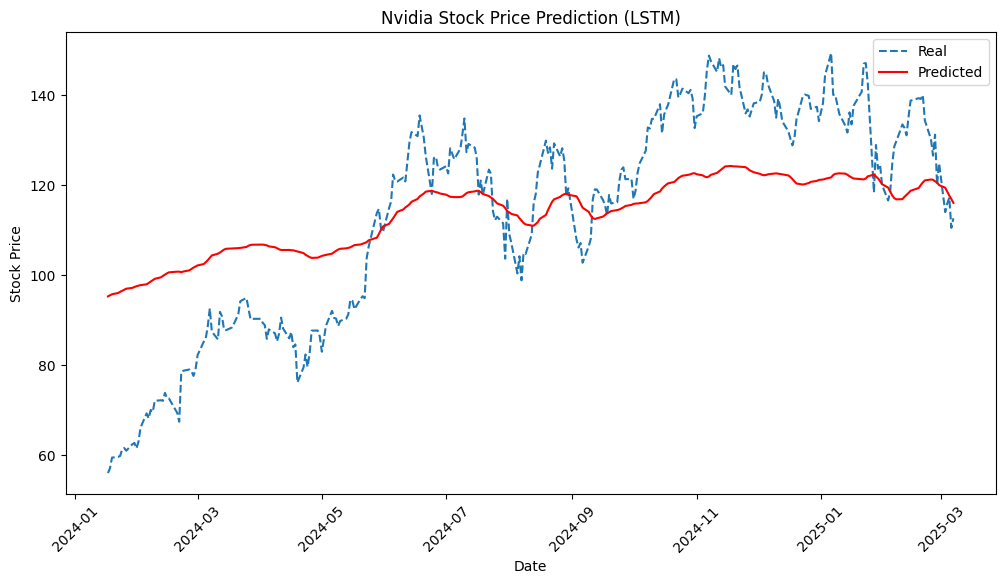

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import json
from sklearn.metrics import mean_squared_error

start_date = "2024-01-01"
end_date = datetime.now()
nvda_data = yf.download("NVDA", start=start_date, end=end_date)

scaler = MinMaxScaler()
nvda_data_scaled = scaler.fit_transform(nvda_data[['Close']])

seq_length = 10
X, Y = [], []
for i in range(len(nvda_data_scaled) - seq_length):
    X.append(nvda_data_scaled[i:i+seq_length])
    Y.append(nvda_data_scaled[i+seq_length])
X, Y = np.array(X), np.array(Y)

X_train = torch.tensor(X, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
predictions = model(X_train).detach().numpy()
predictions = scaler.inverse_transform(predictions)
Y_real = scaler.inverse_transform(Y_train.numpy())

rmse = np.sqrt(mean_squared_error(Y_real, predictions))
print("RMSE:", rmse)

try:
    from properscoring import crps_gaussian
    sigma = np.std(Y_real.flatten() - predictions.flatten())
    crps = np.mean(crps_gaussian(Y_real.flatten(), predictions.flatten(), sigma))
    print("CRPS:", crps)
except ModuleNotFoundError:
    print("properscoring module not installed; cannot compute CRPS.")
    crps = None

dates = nvda_data.index[seq_length:]
plt.figure(figsize=(12,6))
plt.plot(dates, Y_real, label="Real", linestyle="dashed")
plt.plot(dates, predictions, label="Predicted", color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Nvidia Stock Price Prediction (LSTM)")
plt.xticks(rotation=45)
plt.show()
